### What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most commonly present to ChatGPT?


In [1]:
import re
import ast
import spacy
import random
import warnings
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from deep_translator import GoogleTranslator
from gensim import models, corpora, similarities
from urllib3.exceptions import NotOpenSSLWarning
%matplotlib inline
pd.set_option('max_colwidth', 600)
warnings.filterwarnings("ignore")

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('./issuedata_cleaned.csv') # data cleaning process done in RQ2

#### Prompt

In [3]:
# extract prompt data from the DataFrame
prompt_list = list(df['Prompt'])

# clean the prompt data by removing newline characters
cleaned_prompts = [str(prompt).replace('\n', '').replace('\r', '') for prompt in prompt_list]

# load the small English model from SpaCy
nlp_model = spacy.load("en_core_web_sm")
excluded_pipes = ["ner", "parser"]

# define a custom tokenizer function
def tokenize_with_lemmas(document):
    with nlp_model.disable_pipes(*excluded_pipes):
        return [token.lemma_ for token in document if token.is_alpha and not token.is_space and not token.is_punct and not token.is_stop and token.pos_ in ["ADJ", "NOUN", "VERB"]]

# tokenize the cleaned prompt data
tokenized_prompts = list(map(tokenize_with_lemmas, nlp_model.pipe(cleaned_prompts, batch_size=32, n_process=6)))

# create a dictionary object from the tokenized data
prompt_dictionary = corpora.Dictionary(tokenized_prompts)

# filter the dictionary to keep words that appear at least 3 times and have a frequency greater than 0.5
prompt_dictionary.filter_extremes(no_below=3, no_above=0.5)
print('Filtered prompt vocabulary size:', len(prompt_dictionary))

# convert the tokenized text data into bag-of-words model format
bag_of_words = [prompt_dictionary.doc2bow(tokens) for tokens in tokenized_prompts]


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-pa

Filtered prompt vocabulary size: 1598


In [4]:
# build an LDA model using the bag-of-words representation, specifying 10 topics and 10 iterations
lda_model1 = models.LdaModel(corpus=bag_of_words, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=prompt_dictionary, random_state=30)
# print the topics generated by the LDA model
lda_model1.print_topics()

[(0,
  '0.076*"line" + 0.052*"module" + 0.027*"import" + 0.027*"file" + 0.024*"kwargs" + 0.020*"fix" + 0.018*"quickedit" + 0.018*"args" + 0.013*"jekyll" + 0.011*"lib"'),
 (1,
  '0.022*"string" + 0.017*"public" + 0.017*"new" + 0.016*"class" + 0.014*"use" + 0.012*"code" + 0.012*"need" + 0.011*"set" + 0.010*"private" + 0.010*"database"'),
 (2,
  '0.026*"token" + 0.016*"language" + 0.016*"stream" + 0.015*"datum" + 0.014*"t" + 0.013*"text" + 0.012*"option" + 0.011*"term" + 0.010*"error" + 0.010*"include"'),
 (3,
  '0.054*"def" + 0.044*"return" + 0.028*"null" + 0.022*"response" + 0.019*"const" + 0.018*"value" + 0.016*"loss" + 0.016*"import" + 0.015*"false" + 0.014*"output"'),
 (4,
  '0.033*"usage" + 0.019*"range" + 0.017*"span" + 0.016*"return" + 0.013*"list" + 0.013*"text" + 0.013*"item" + 0.012*"server" + 0.012*"client" + 0.012*"info"'),
 (5,
  '0.022*"src" + 0.019*"pm" + 0.015*"student" + 0.012*"local" + 0.012*"schedule" + 0.012*"language" + 0.011*"model" + 0.011*"program" + 0.010*"operat

In [5]:
# calculate the proportion of each topic across all prompts
topic_distributions = list(lda_model1.get_document_topics(bag_of_words, minimum_probability=0))
# iterate through each topic to calculate and display its proportion
for topic_index in range(10):
    topic_percentage = 100 * sum(pair[topic_index][1] for pair in topic_distributions) / len(topic_distributions)
    print('Topic {}: {:.1f}%'.format(topic_index, topic_percentage))

Topic 0: 10.4%
Topic 1: 18.1%
Topic 2: 9.6%
Topic 3: 7.5%
Topic 4: 9.0%
Topic 5: 9.6%
Topic 6: 12.2%
Topic 7: 7.1%
Topic 8: 7.5%
Topic 9: 9.1%


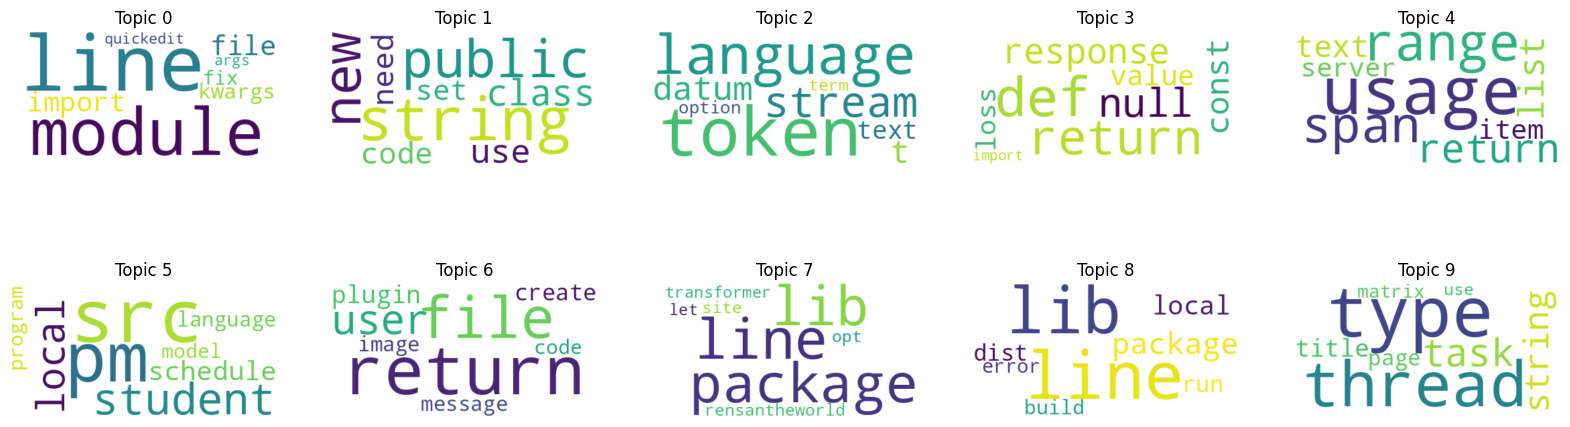

In [6]:
# plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=8)
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

# generate and display word clouds for each topic
for index, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model1.show_topic(index))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {index}')
    plt.gca().axis('off')
# show the plot
plt.show()

#### Answer

In [7]:
# extract answer data from the DataFrame
answer_list = list(df['Answer'])
# clean the answer data by removing newline characters
cleaned_answers = [str(answer).replace('\n', '').replace('\r', '') for answer in answer_list]

# load the small English model from SpaCy
nlp_model = spacy.load("en_core_web_sm")
excluded_pipes = ["ner", "parser"]

# define a custom tokenizer function
def tokenize_with_lemmas(document):
    with nlp_model.disable_pipes(*excluded_pipes):
        return [token.lemma_ for token in document if token.is_alpha and not token.is_space and not token.is_punct and not token.is_stop and token.pos_ in ["ADJ", "NOUN", "VERB"]]

# tokenize the cleaned answer data
tokenized_answers = list(map(tokenize_with_lemmas, nlp_model.pipe(cleaned_answers, batch_size=32, n_process=6)))

# create a dictionary object from the tokenized data
answer_dictionary = corpora.Dictionary(tokenized_answers)

# filter the dictionary to keep words that appear at least 3 times and have a frequency greater than 0.5
answer_dictionary.filter_extremes(no_below=3, no_above=0.5)
print('Filtered answer vocabulary size:', len(answer_dictionary))

# convert the tokenized text data into bag-of-words model format
bag_of_words = [answer_dictionary.doc2bow(tokens) for tokens in tokenized_answers]


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-pa

Filtered answer vocabulary size: 2878


In [8]:
# build an LDA model using the bag-of-words representation, specifying 10 topics and 10 iterations
lda_model2 = models.LdaModel(corpus=bag_of_words, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=answer_dictionary, random_state=30)
# print the topics generated by the LDA model
lda_model2.print_topics()

[(0,
  '0.018*"user" + 0.017*"message" + 0.015*"datum" + 0.014*"stream" + 0.012*"use" + 0.012*"need" + 0.010*"handle" + 0.008*"protocol" + 0.008*"provide" + 0.007*"key"'),
 (1,
  '0.017*"use" + 0.014*"need" + 0.013*"method" + 0.012*"request" + 0.012*"update" + 0.010*"server" + 0.010*"application" + 0.010*"component" + 0.010*"example" + 0.009*"tag"'),
 (2,
  '0.014*"search" + 0.011*"document" + 0.010*"phrase" + 0.009*"source" + 0.009*"datum" + 0.009*"number" + 0.007*"unique" + 0.007*"word" + 0.007*"bit" + 0.007*"provide"'),
 (3,
  '0.026*"table" + 0.019*"query" + 0.018*"department" + 0.016*"salary" + 0.016*"column" + 0.015*"string" + 0.015*"name" + 0.015*"use" + 0.013*"base" + 0.013*"employee"'),
 (4,
  '0.037*"file" + 0.016*"code" + 0.015*"directory" + 0.015*"run" + 0.014*"error" + 0.013*"issue" + 0.012*"package" + 0.011*"use" + 0.011*"module" + 0.011*"command"'),
 (5,
  '0.042*"model" + 0.018*"code" + 0.012*"provide" + 0.011*"method" + 0.011*"function" + 0.010*"class" + 0.009*"file" +

In [9]:
# calculate the proportion of each topic across all answers
topic_distributions = list(lda_model2.get_document_topics(bag_of_words, minimum_probability=0))
# iterate through each topic to calculate and display its proportion
for topic_index in range(10):
    topic_percentage = 100 * sum(pair[topic_index][1] for pair in topic_distributions) / len(topic_distributions)
    print('Topic {}: {:.1f}%'.format(topic_index, topic_percentage))

Topic 0: 11.9%
Topic 1: 9.2%
Topic 2: 9.1%
Topic 3: 8.5%
Topic 4: 21.6%
Topic 5: 12.0%
Topic 6: 6.5%
Topic 7: 6.6%
Topic 8: 7.3%
Topic 9: 7.4%


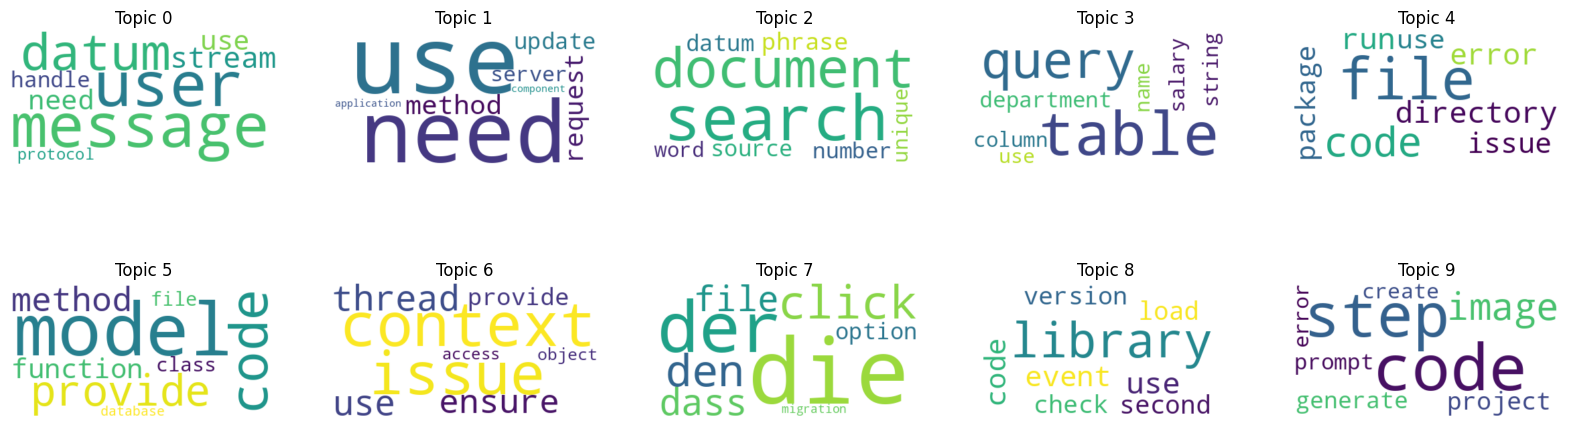

In [10]:
# plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=8)
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

# generate and display word clouds for each topic
for index, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model2.show_topic(index))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {index}')
    plt.gca().axis('off')
# show the plot
plt.show()